**I. Data upload, preparation and normalization**

1. Importing packages and libraries.

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelextrema, peak_widths
from scipy.optimize import curve_fit
from pybaselines import Baseline
from sklearn.metrics import auc
import cv2
#tuckeys test

In [2]:
# 141 116 48 49 28

In [3]:
cy5_excel = "data/1 T19G + U19U CY5.xlsx"

In [4]:
grey_values_list = ["Grey_Values_T0", "Grey_Values_T10s", "Grey_Values_T30s", "Grey_Values_T1M", "Grey_Values_T3M", "Grey_Values_T6M",
                   "Grey_Values_T30M", "Grey_Values_T100M", "Grey_Values_L1", "Grey_Values_L2"]

In [5]:
# Uploading the data of all lanes.

#CY5
data_cy5 = pd.read_excel(cy5_excel)

for d in data_cy5:
    for l in grey_values_list:
        if d == l:
            data_cy5 = data_cy5.rename(columns={d: d+'_CY5'})

In [6]:
data = data_cy5.filter(["Distance", "Grey_Values_T6M_CY5"], axis=1)

Text(0, 0.5, 'Intensity Values')

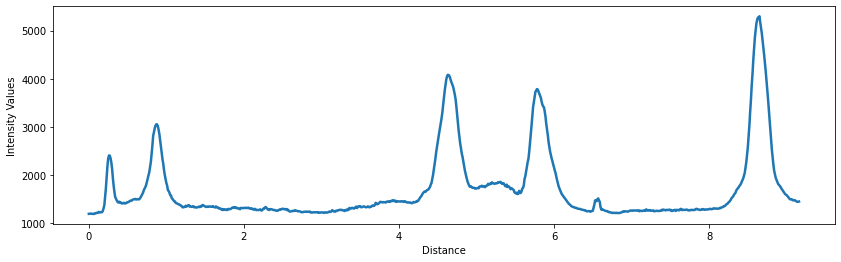

In [7]:
plt.figure(figsize=(14, 4))
plt.plot(data["Distance"],data["Grey_Values_T6M_CY5"], linewidth = 2.5)

plt.xlabel("Distance")
plt.ylabel("Intensity Values")
#plt.legend()


2. Removing background.

In [8]:
baseline_fitter = Baseline(x_data=data["Distance"])
imodpoly = baseline_fitter.imodpoly(data["Grey_Values_T6M_CY5"], poly_order=3, num_std=0.8)
new_y = data["Grey_Values_T6M_CY5"]-imodpoly[0]
new_y[new_y < 0] = 0
data["Grey_Values_T6M_CY5_baseline"] = new_y

Text(0, 0.5, 'Intensity Values')

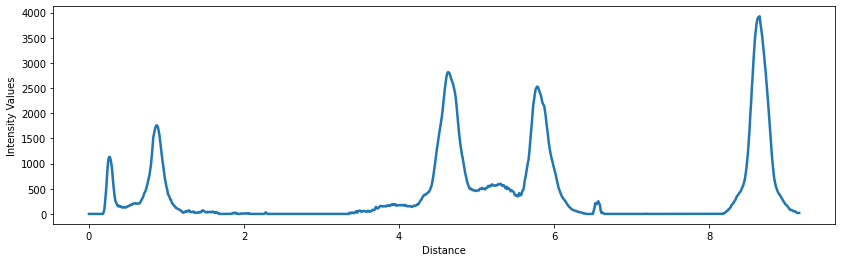

In [9]:
plt.figure(figsize=(14, 4))
plt.plot(data["Distance"],data["Grey_Values_T6M_CY5_baseline"], linewidth = 2.5)

plt.xlabel("Distance")
plt.ylabel("Intensity Values")

3. Creating test data - adjusting the height of the peaks, removing most of the imperfections.

In [10]:
new_y2 = data["Grey_Values_T6M_CY5_baseline"]*2
new_y2[new_y2 < 1200] = 1200
data["Grey_Values_T6M_CY5_baseline_2"] = new_y2

Text(0, 0.5, 'Intensity Values')

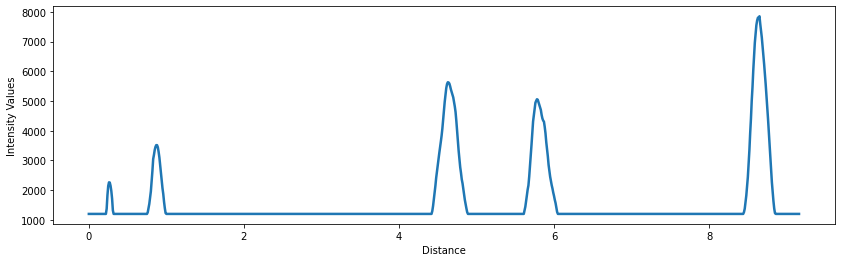

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(data["Distance"],data["Grey_Values_T6M_CY5_baseline_2"], linewidth = 2.5)

plt.xlabel("Distance")
plt.ylabel("Intensity Values")

In [12]:
baseline_fitter = Baseline(x_data=data["Distance"])
imodpoly3 = baseline_fitter.imodpoly(data["Grey_Values_T6M_CY5_baseline_2"], poly_order=3, num_std=0.8)
new_y3 = data["Grey_Values_T6M_CY5_baseline_2"]-imodpoly3[0]
new_y3[new_y3 < 0] = 0
data["Grey_Values_T6M_CY5_baseline_3"] = new_y3

Text(0, 0.5, 'Intensity Values')

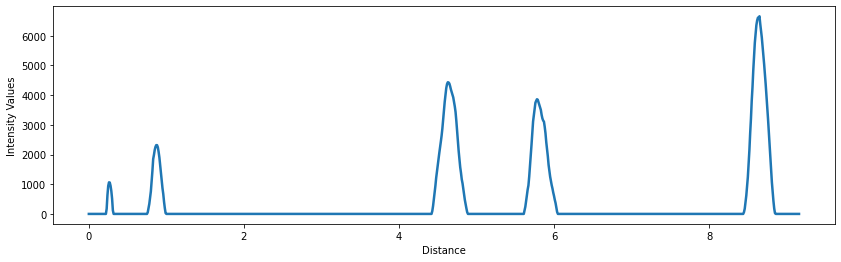

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(data["Distance"],data["Grey_Values_T6M_CY5_baseline_3"], linewidth = 2.5)

plt.xlabel("Distance")
plt.ylabel("Intensity Values")

4. Normalizing the distance in the test lane.

In [14]:
peaks_list = []
peaks, values = find_peaks(data["Grey_Values_T6M_CY5_baseline_3"], height=1000)
peak_values = data.iloc[peaks, 0]
peak_values = list(peak_values)
peak_data = (peak_values)
peaks_list.append(peak_data)

In [15]:
peaks_list

[[0.26, 0.87, 4.63, 5.78, 8.65]]

In [16]:
# Markers (min and max values of peaks of each lane) are taken only from CY5 - CY3 tends to be more inconsitent.

min_max_list = []

for i in peaks_list:
    min_peak = i[0]
    max_peak = i[-1]
    min_max = list((min_peak, max_peak))
    min_max_list.append(min_max)
min_max_list = min_max_list
min_max_list

[[0.26, 8.65]]

In [17]:
# Normalizing the distance

norm_list = []
name_list = ["Test Data"]

for i, n in min_max_list:
    norm_distance = ((data["Distance"] - i) / (n - i))
    norm_list.append(norm_distance)

data["Test_Data_norm_distance"] = np.reshape(norm_list, (-1, 1))

In [18]:
data

,Distance,Grey_Values_T6M_CY5,Grey_Values_T6M_CY5_baseline,Grey_Values_T6M_CY5_baseline_2,Grey_Values_T6M_CY5_baseline_3,Test_Data_norm_distance
0,0.00,1191.111,0.000000,1200.0,0.000000e+00,-0.030989
1,0.01,1194.000,0.000000,1200.0,0.000000e+00,-0.029797
2,0.02,1195.000,0.000000,1200.0,0.000000e+00,-0.028605
3,0.03,1195.556,0.000000,1200.0,0.000000e+00,-0.027414
4,0.04,1191.333,0.000000,1200.0,0.000000e+00,-0.026222
...,...,...,...,...,...,...
912,9.12,1459.444,37.277503,1200.0,2.273737e-13,1.056019
913,9.13,1445.333,21.972089,1200.0,2.273737e-13,1.057211
914,9.14,1442.333,17.772440,1200.0,2.273737e-13,1.058403
915,9.15,1443.333,17.567548,1200.0,2.273737e-13,1.059595


5. Plotting the 0-1 normalized data.

Text(0, 0.5, 'Intensity Values')

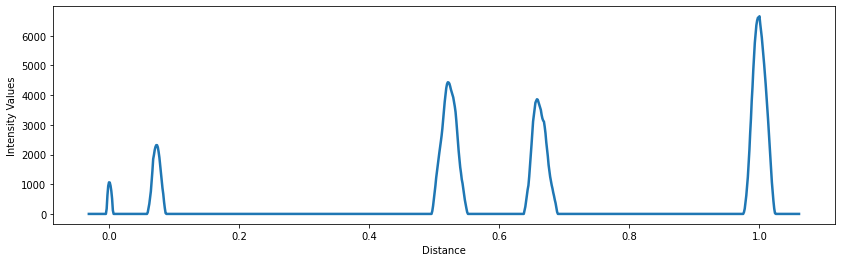

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(data["Test_Data_norm_distance"],data["Grey_Values_T6M_CY5_baseline_3"], linewidth = 2.5)

plt.xlabel("Distance")
plt.ylabel("Intensity Values")

(0.0, 1.0)

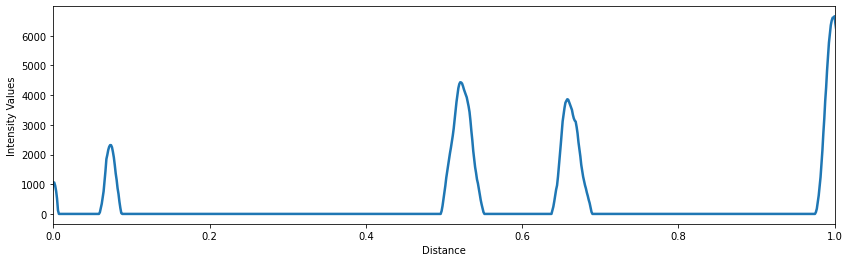

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(data["Test_Data_norm_distance"],data["Grey_Values_T6M_CY5_baseline_3"], linewidth = 2.5)

plt.xlabel("Distance")
plt.ylabel("Intensity Values")
plt.xlim(0, 1)

**II. Ladder**

1. Finding the peak values. 

In [21]:
data_ladder = pd.read_csv("Ladder1_CY5_norm_distance.csv", comment='#',sep=',')
data_ladder.loc[len(data_ladder)] = {"Ladder1_CY5_norm_distance" : 1.059032, "Grey_Values_L1_CY5_baseline" : 22.244741}
data_ladder

,Ladder1_CY5_norm_distance,Grey_Values_L1_CY5_baseline
0,-0.021251,62.113821
1,-0.020071,56.665855
2,-0.018890,67.712876
3,-0.017710,75.921902
4,-0.016529,78.514952
...,...,...
912,1.055490,0.000000
913,1.056671,14.202663
914,1.057851,19.606698
915,1.059032,22.244741


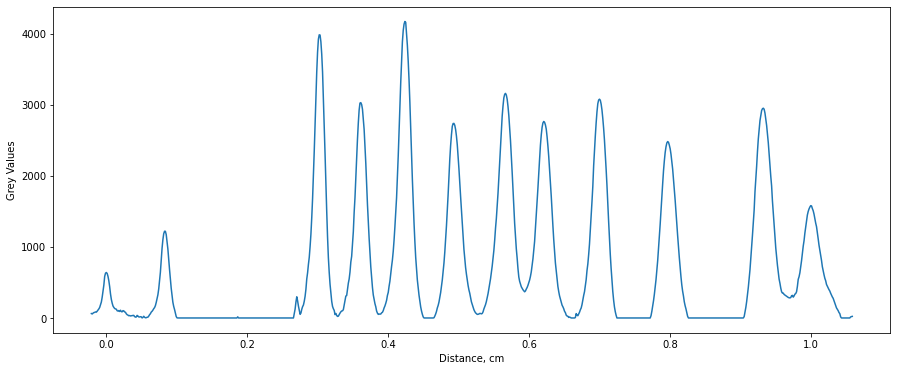

In [22]:
#Laddder lane 1 (CY5)

plt.figure(figsize=(15,6))
plot = plt.plot(data_ladder["Ladder1_CY5_norm_distance"], data_ladder['Grey_Values_L1_CY5_baseline'])
plt.xlabel("Distance, cm")
plt.ylabel("Grey Values")

plt.show()

In [23]:
#Finding ladder 1 peak values:

peaks_l1, values_l1 = find_peaks(data_ladder['Grey_Values_L1_CY5_baseline'], height=600)
peak_values_l1 = data_ladder.iloc[peaks_l1, 0]
peak_values_l1 = list(peak_values_l1)
peak_values_l1

[0.0,
 0.0826446280991735,
 0.3022432113341204,
 0.3612750885478158,
 0.4238488783943329,
 0.4935064935064935,
 0.5667060212514758,
 0.6210153482880756,
 0.7001180637544274,
 0.7969303423848878,
 0.9327036599763872,
 1.0]

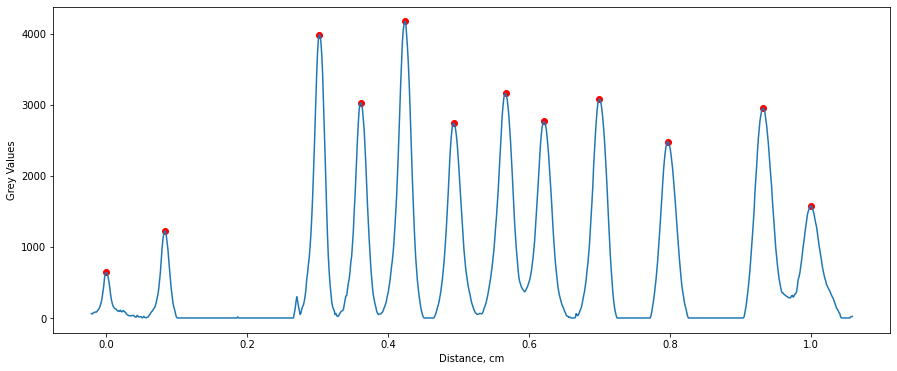

In [24]:
plt.figure(figsize=(15,6))
plot = plt.plot(data_ladder["Ladder1_CY5_norm_distance"], data_ladder['Grey_Values_L1_CY5_baseline'])
plt.scatter(peak_values_l1, values_l1.values(), color='red')
plt.xlabel("Distance, cm")
plt.ylabel("Grey Values")
plt.show()

In [25]:
cut_x_data = data_ladder['Ladder1_CY5_norm_distance']
cut_x_data = cut_x_data[peaks_l1[0]:peaks_l1[-1]+1]

cut_y_data = data_ladder['Grey_Values_L1_CY5_baseline']
cut_y_data = cut_y_data[peaks_l1[0]:peaks_l1[-1]+1]

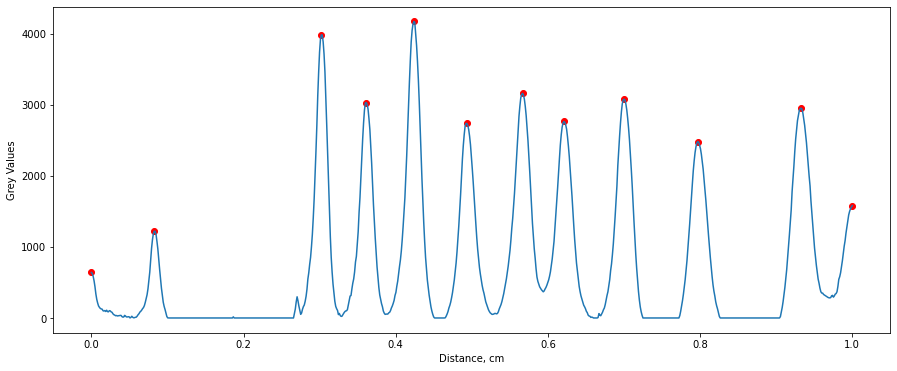

In [26]:
plt.figure(figsize=(15,6))
plot = plt.plot(cut_x_data, cut_y_data)
plt.scatter(peak_values_l1, values_l1.values(), color='red')
plt.xlabel("Distance, cm")
plt.ylabel("Grey Values")
plt.show()

In [27]:
peak_values_l1

[0.0,
 0.0826446280991735,
 0.3022432113341204,
 0.3612750885478158,
 0.4238488783943329,
 0.4935064935064935,
 0.5667060212514758,
 0.6210153482880756,
 0.7001180637544274,
 0.7969303423848878,
 0.9327036599763872,
 1.0]

2.1  Converting distance to nt. Exponential distance between peaks based on a single equation of all data points.

In [28]:
ladder_lane = [141, 116, 81, 71, 66, 60, 55, 51, 46, 41, 35, 28]

In [29]:
ladder_df = pd.DataFrame(ladder_lane, columns=["Ladder"])
values_df = pd.DataFrame(peak_values_l1, columns=["Norm. distance"])
curve_data = pd.concat([ladder_df, values_df], axis=1)
curve_data 

,Ladder,Norm. distance
0,141,0.000000
1,116,0.082645
2,81,0.302243
3,71,0.361275
4,66,0.423849
5,60,0.493506
6,55,0.566706
7,51,0.621015
8,46,0.700118
9,41,0.796930


In [30]:
def fitting_function(xs, ys):

    const_list = []
    
    # perform the fit
    p0 = (60, 1, 30) # start with values near those we expect
    params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0, maxfev=5000)
    m, t, b = params

    # determine quality of the fit
    squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
    squaredDiffsFromMean = np.square(ys - np.mean(ys))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    print(f"R² = {rSquared}")

    # plot the results
    plt.figure(figsize=(10,6))
    plt.plot(xs, ys, '.', label="data")
    model_x = np.arange(np.min(xs), np.max(xs), step = 0.01)
    plt.plot(model_x, monoExp(model_x, m, t, b), label="fitted")
   # plt.title("Fitted Exponential Curve")

    # inspect the parameters
    print(f"Y = {m} * e^(-{t} * x) + {b}")
    
    const_list.append(m)
    const_list.append(t)
    const_list.append(b)
    
    return const_list

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b
    

In [31]:
curve_data_list = curve_data.values.tolist()
curve_data_list

[[141.0, 0.0],
 [116.0, 0.0826446280991735],
 [81.0, 0.3022432113341204],
 [71.0, 0.3612750885478158],
 [66.0, 0.4238488783943329],
 [60.0, 0.4935064935064935],
 [55.0, 0.5667060212514758],
 [51.0, 0.6210153482880756],
 [46.0, 0.7001180637544274],
 [41.0, 0.7969303423848878],
 [35.0, 0.9327036599763872],
 [28.0, 1.0]]

In [32]:
curve_data_list_nt = []
curve_data_list_dist = []

for i, n  in curve_data_list:
    curve_data_list_nt.append(i)
    curve_data_list_dist.append(n)

In [33]:
overlap = 3
size = 4

overlap_list_nt = []
overlap_list_dist = []

for i in range(0, len(curve_data_list_nt) - overlap, size - overlap):            
    k = curve_data_list_nt[i:i + size]
    j = curve_data_list_dist[i:i + size]
    overlap_list_nt.append(k)
    overlap_list_dist.append(j)

R² = 0.9973061062285651
Y = 96.09260744687752 * e^(-3.397956201636122 * x) + 44.44466946923468
R² = 0.9976127623185304
Y = 130.26190192856623 * e^(-1.7515356635012216 * x) + 3.3470791506247637
R² = 0.9941719305129492
Y = 198.18202525463786 * e^(-6.344742435112345 * x) + 51.68361645262407
R² = 0.9990625639980268
Y = 116.03180225430167 * e^(-1.1582517356950015 * x) + -5.2692992234485
R² = 0.999150702311496
Y = 109.4746309943428 * e^(-1.4978616008153203 * x) + 7.918521522757574
R² = 0.9995603679788201
Y = 162.48908968857475 * e^(-0.5992248141215716 * x) + -60.851395784520676
R² = 0.9999999998761949
Y = 125.50695681662263 * e^(-2.304136597179683 * x) + 20.99212630083054
R² = 0.9999145158268758
Y = 111.93448988038716 * e^(-1.7235809216290654 * x) + 12.590254008269186
R² = 0.9706423541092315
Y = 46799.775352211625 * e^(-0.0012155493629475518 * x) + -46713.52368150929


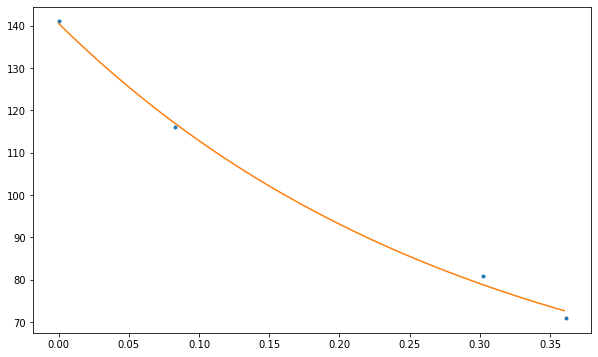

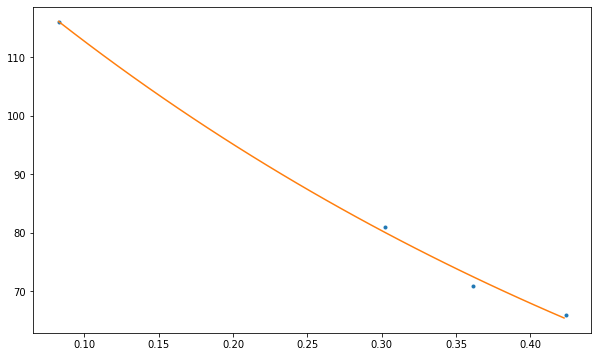

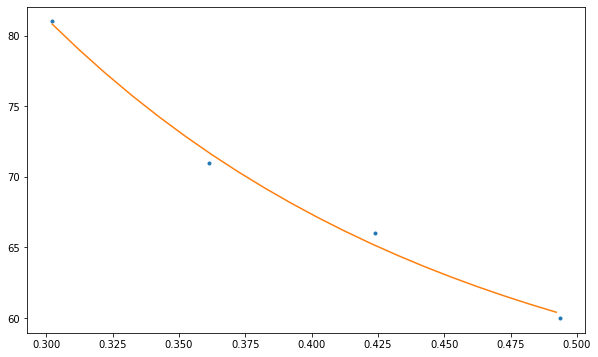

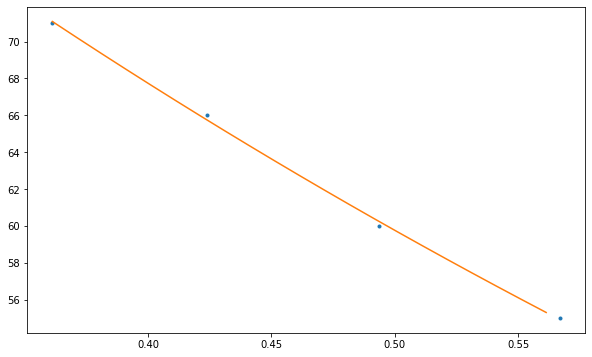

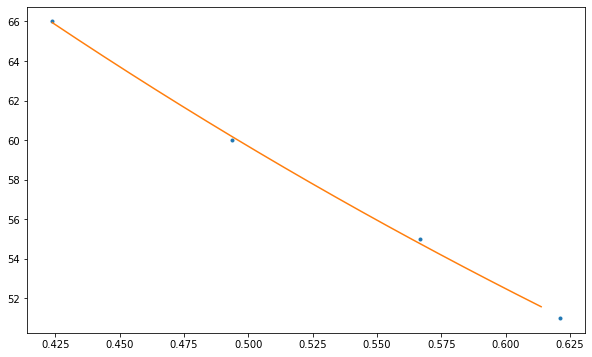

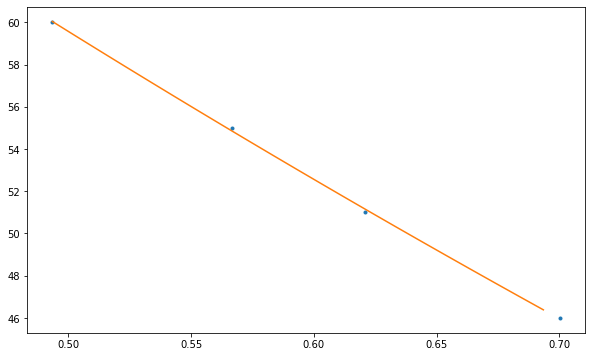

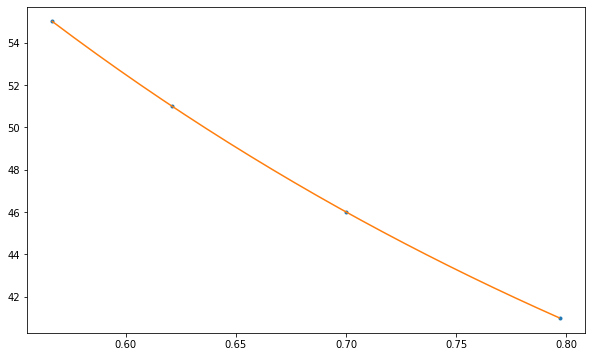

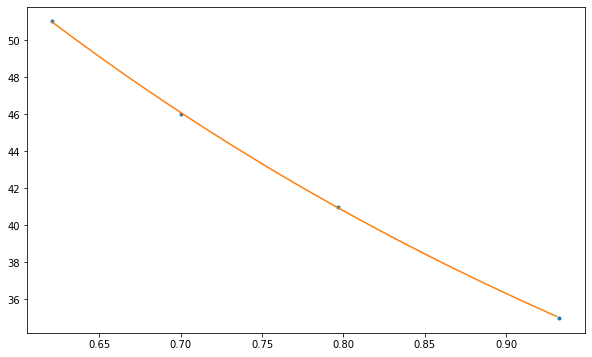

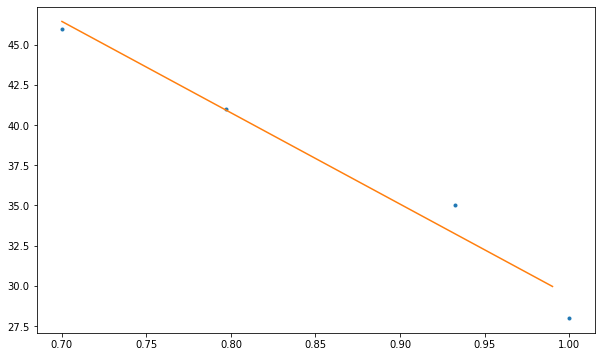

In [34]:
values_list = []
for i in range(len(overlap_list_dist)):
    xs = np.array(overlap_list_dist[i])
    ys = np.array(overlap_list_nt[i])
    a = fitting_function(xs, ys)
    values_list.append(a)

In [35]:
ranges_list = []
data_ranges_list = []

for i in range(len(peaks_l1)):
    if i+1 != len(peaks_l1):
        ranges = list((peaks_l1[i], peaks_l1[i+1]))
        ranges_list.append(ranges)

for i, n in ranges_list:
    data_range = list(cut_x_data[i-peaks_l1[0]:n-peaks_l1[0]+1])
    data_ranges_list.append(data_range)

In [36]:
# Dividing data into ranges and removing overlapping values 

new_data_ranges_list = [list(dict.fromkeys(data_ranges_list[0]+data_ranges_list[1])), data_ranges_list[2], data_ranges_list[3],
                       data_ranges_list[4], data_ranges_list[5], data_ranges_list[6], data_ranges_list[7], data_ranges_list[8],
                       list(dict.fromkeys(data_ranges_list[9]+data_ranges_list[10]))]

for i in range(len(new_data_ranges_list)-1):
    remove_last = new_data_ranges_list[i]
    del remove_last[-1]

In [37]:
exp_x_list_4p = []

for j, k in enumerate(new_data_ranges_list):
    for i in k:
        values_list1 = values_list[j]
        value = values_list1[0] * math.exp(-values_list1[1]*i)+values_list1[2]
        exp_x_list_4p.append(value)
        
exp_x_list_4p

[140.5372769161122,
 140.15254918250156,
 139.76936179036923,
 139.38770857262182,
 139.00758338685716,
 138.62898011526568,
 138.25189266453165,
 137.87631496573533,
 137.50224097425527,
 137.1296646696709,
 136.75858005566567,
 136.38898115993078,
 136.02086203406873,
 135.65421675349768,
 135.28903941735632,
 134.92532414840863,
 134.56306509294933,
 134.20225642070986,
 133.84289232476428,
 133.484967021436,
 133.1284747502047,
 132.77340977361348,
 132.41976637717664,
 132.06753886928766,
 131.7167215811276,
 131.36730886657386,
 131.01929510210937,
 130.67267468673208,
 130.32744204186463,
 129.98359161126484,
 129.64111786093608,
 129.30001527903835,
 128.96027837579948,
 128.62190168342673,
 128.28487975601897,
 127.94920716947888,
 127.61487852142571,
 127.28188843110829,
 126.95023153931845,
 126.61990250830486,
 126.290896021687,
 125.9632067843696,
 125.63682952245749,
 125.31175898317072,
 124.98798993475995,
 124.6655171664223,
 124.34433548821751,
 124.02443973098431,
 1

**3. AUC**

1. Applying conversion to nt.

In [38]:
cut_test_distance_data = data["Test_Data_norm_distance"]
cut_test_distance_data = cut_test_distance_data[peaks_l1[0]:peaks_l1[-1]+1]

cut_test_grey_data = data["Grey_Values_T6M_CY5_baseline_3"]
cut_test_grey_data = cut_test_grey_data[peaks_l1[0]:peaks_l1[-1]+1]

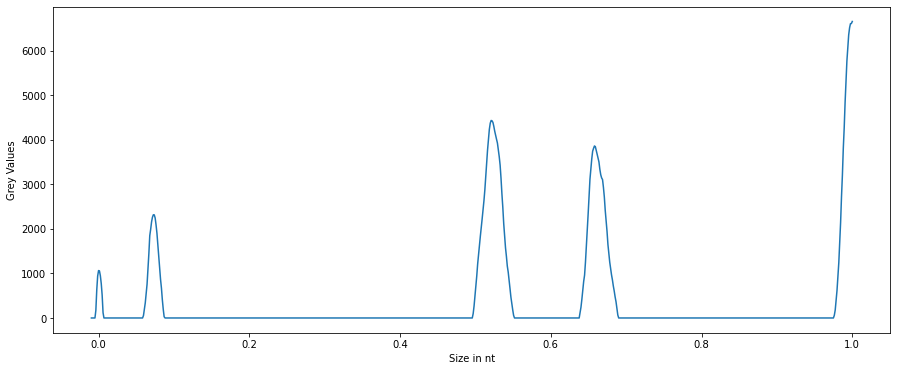

In [39]:
plt.figure(figsize=(15,6))
plot = plt.plot(cut_test_distance_data, cut_test_grey_data)####
#ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt")
plt.ylabel("Grey Values")
plt.show()

In [40]:
# Creating new data ranges for test data

data_ranges_list_test = []

for i, n in ranges_list:
    data_range = list(cut_test_distance_data[i-peaks_l1[0]:n-peaks_l1[0]+1])
    data_ranges_list_test.append(data_range)

In [41]:
# Dividing data into ranges and removing overlapping values 

new_data_ranges_list_test = [list(dict.fromkeys(data_ranges_list_test[0]+data_ranges_list_test[1])), data_ranges_list_test[2], data_ranges_list_test[3],
                       data_ranges_list_test[4], data_ranges_list_test[5], data_ranges_list_test[6], data_ranges_list_test[7], data_ranges_list_test[8],
                       list(dict.fromkeys(data_ranges_list_test[9]+data_ranges_list_test[10]))]

for i in range(len(new_data_ranges_list_test)-1):
    remove_last = new_data_ranges_list_test[i]
    del remove_last[-1]

In [42]:
exp_test_x_list = []

for j, k in enumerate(new_data_ranges_list_test):
    for i in k:
        values_list1 = values_list[j]
        value = values_list1[0] * math.exp(-values_list1[1]*i)+values_list1[2]
        exp_test_x_list.append(value)

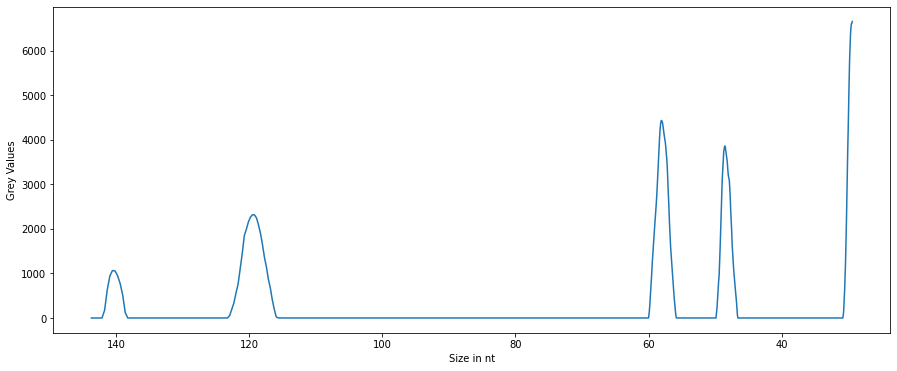

In [43]:
plt.figure(figsize=(15,6))
plot = plt.plot(exp_test_x_list, cut_test_grey_data)####
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt")
plt.ylabel("Grey Values")
plt.show()

In [44]:
values_ladder = pd.DataFrame(exp_test_x_list, columns=["Exp X"])
cut_data = pd.concat([values_ladder, cut_test_grey_data.reset_index()], axis=1)
cut_data

,Exp X,index,Grey_Values_T6M_CY5_baseline_3
0,143.701670,18,0.000000
1,143.300491,19,0.000000
2,142.900934,20,0.000000
3,142.502991,21,0.000000
4,142.106658,22,0.000000
...,...,...,...
843,29.669681,861,6353.190815
844,29.601959,862,6512.419697
845,29.534238,863,6605.641117
846,29.466516,864,6608.741056


In [45]:
peaks_list = []
peaks, values = find_peaks(cut_test_grey_data, height=1000)
peak_values = cut_data.iloc[peaks, 0]
peak_values = list(peak_values)
peak_data = (peak_values)
peaks_list.append(peak_data)

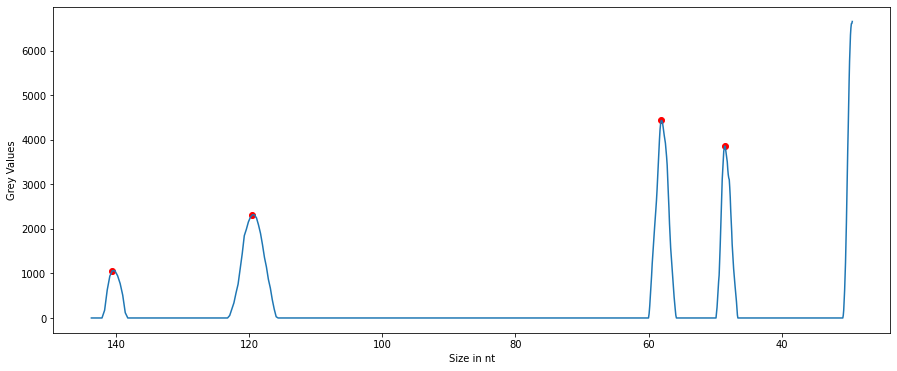

In [46]:
plt.figure(figsize=(15,6))
plot = plt.plot(exp_test_x_list, cut_test_grey_data)####
plt.scatter(peak_values, values.values(), color='red')
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt")
plt.ylabel("Grey Values")
plt.show()

In [50]:
widths, width_heights, left_ips, right_ips = peak_widths(cut_test_grey_data, peaks, rel_height=1)

In [52]:
from scipy.interpolate import interp1d

def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)

widths1 = index_to_xdata(exp_test_x_list, widths)
left_ips1 = index_to_xdata(exp_test_x_list, left_ips)
right_ips1 = index_to_xdata(exp_test_x_list, right_ips)

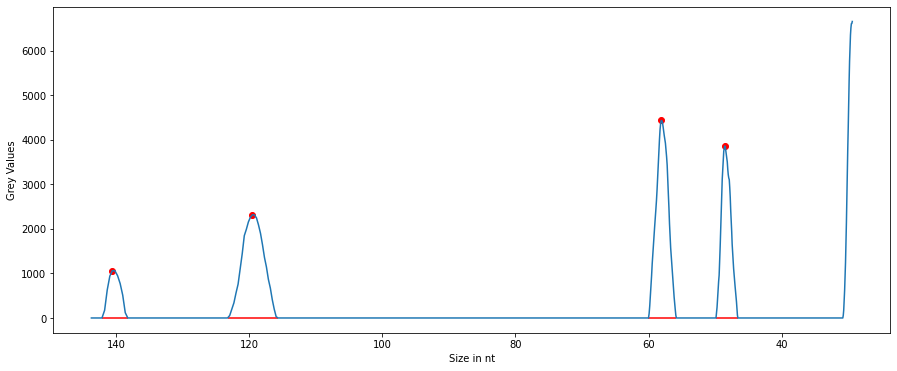

In [53]:
plt.figure(figsize=(15,6))
plot = plt.plot(exp_test_x_list, cut_test_grey_data)####
plt.scatter(peak_values, values.values(), color='red')
plt.hlines(width_heights, left_ips1, right_ips1, color='r')
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt")
plt.ylabel("Grey Values")
plt.show()

2. Selecting intact DNA area.

In [54]:
left_ips = list(left_ips)
right_ips = list(right_ips)
for i, n in enumerate(left_ips):
    left_ips[i] = int(n)
    
for i, n in enumerate(right_ips):
    right_ips[i] = int(n)


In [55]:
intact_dna_area = auc(exp_test_x_list[left_ips[1]:right_ips[1]], cut_test_grey_data[left_ips[1]:right_ips[1]])

In [56]:
intact_dna_area

9067.775834704938

3. Selecting cut DNA I area.

In [57]:
cut_dna_i_area = auc(exp_test_x_list[left_ips[2]:right_ips[2]], cut_test_grey_data[left_ips[2]:right_ips[2]])

In [58]:
cut_dna_i_area

9685.47329463074

4. Selecting cut DNA II area.

In [59]:
cut_dna_ii_area = auc(exp_test_x_list[left_ips[3]:right_ips[3]], cut_test_grey_data[left_ips[3]:right_ips[3]])

In [60]:
cut_dna_ii_area

6570.653960720685

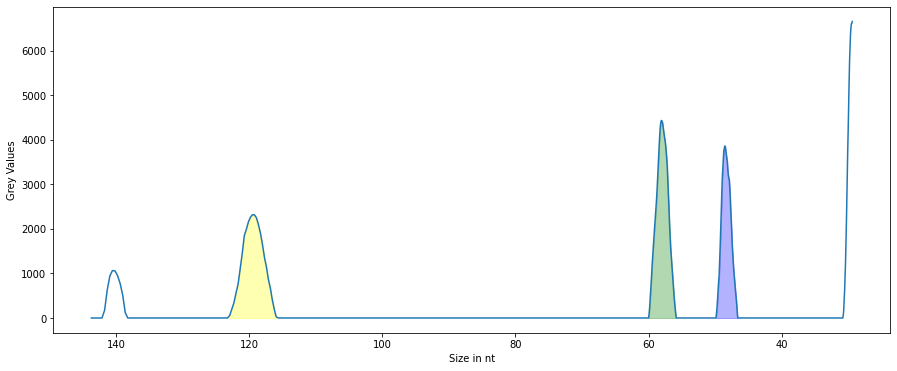

In [61]:
plt.figure(figsize=(15,6))
plot = plt.plot(exp_test_x_list, cut_test_grey_data)####
plt.fill_between(exp_test_x_list[left_ips[1]:right_ips[1]], cut_test_grey_data[left_ips[1]:right_ips[1]], color='yellow', alpha=0.3)
plt.fill_between(exp_test_x_list[left_ips[2]:right_ips[2]], cut_test_grey_data[left_ips[2]:right_ips[2]], color='green', alpha=0.3)
plt.fill_between(exp_test_x_list[left_ips[3]:right_ips[3]], cut_test_grey_data[left_ips[3]:right_ips[3]], color='blue', alpha=0.3)
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt")
plt.ylabel("Grey Values")
plt.show()

5. Normalizing the each area with the total area.

In [62]:
total_area = intact_dna_area+cut_dna_i_area+cut_dna_ii_area
total_area

25323.903090056367

In [66]:
intact_norm_list = []
intact_norm = intact_dna_area/total_area
intact_norm_list.append(intact_norm)
intact_norm_list

[0.35807181074964206]

In [68]:
cut_dna_i_norm_list = []
cut_dna_i_norm = cut_dna_i_area/total_area
cut_dna_i_norm_list.append(cut_dna_i_norm)
cut_dna_i_norm_list

[0.3824636850088807]

In [69]:
cut_dna_ii_norm_list = []
cut_dna_ii_norm = cut_dna_ii_area/total_area
cut_dna_ii_norm_list.append(cut_dna_ii_norm)
cut_dna_ii_norm_list

[0.2594645042414771]

In [71]:
#auc_percent_substrate_list[-1] = 0
#time_points = [0, 10, 30, 60, 180, 360, 1800, 6000]
time_points = [360]
time = pd.DataFrame(time_points, columns=["Time_Points, s"])
auc_int_dna = pd.DataFrame(intact_norm_list, columns=["Intact DNA"])
auc_cut_dna_i = pd.DataFrame(cut_dna_i_norm_list, columns=["Cut DNA I"])
auc_cut_dna_ii = pd.DataFrame(cut_dna_ii_norm_list, columns=["Cut DNA II"])
df = pd.concat([time, auc_int_dna, auc_cut_dna_i, auc_cut_dna_ii], axis=1)
df

,"Time_Points, s",Intact DNA,Cut DNA I,Cut DNA II
0,360,0.358072,0.382464,0.259465


In [72]:
df.to_csv('analysis_results.csv', encoding='utf-8', index = False, header = False)